# Identifying 2D Ising Model Phases with Logistic Regression

In this notebook we use the binary classification method logistic regression to determine the phases of the two-dimensional Ising model.

### Configure notebook

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import pickle
import urllib

import warnings
# Comment this to turn on warnings
warnings.filterwarnings('ignore')

# Import code from src
sys.path.insert(0, '../src/')
from logisticmodel import LogisticRegression
from project_tools import fig_path

# Set fontsizes in figures
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'legend.fontsize': 'large',
          'legend.handlelength': 2}
plt.rcParams.update(params)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


### Ising model parameters

In [2]:
np.random.seed(42) # shuffle random seed generator

# Ising model parameters
L = 40                          # linear system size
J = -1.0                        # Ising interaction
T = np.linspace(0.25, 4.0, 16)  # set of temperatures
T_c = 2.26                      # Onsager critical temperature in the TD limit

### Download data set

In [3]:
# Run this cell to load data from web.
# Downloaded files will be stored locally, i.e. one run of this cell is enough
# Warning: data set is approx 2GB

url_main = "https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/"
data_file_name = "Ising2DFM_reSample_L40_T=All.pkl"
label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"

labels = pickle.load(urllib.request.urlopen(url_main + label_file_name))

data = pickle.load(urllib.request.urlopen(url_main + data_file_name))
data = np.unpackbits(data).reshape(-1, 1600)
data = data.astype('int')

np.save("labels", labels)
np.save("spin_data", data)

del data, labels

### Load data set

In [4]:
X = np.load("spin_data.npy")
y = np.load("labels.npy")

# divide data into ordered, critical and disordered
X_ordered = X[:70000,:]
y_ordered = y[:70000]

X_critical = X[70000:100000,:]
y_critical = y[70000:100000]

X_disordered = X[100000:,:]
y_disordered = y[100000:]

# define training and test data sets
X = np.concatenate((X_ordered, X_disordered))
y = np.concatenate((y_ordered, y_disordered))

# create the training and test sets
logreg = LogisticRegression()
X_train, X_test, y_train, y_test = logreg.split_data(X, y, test_ratio=0.5)

# full data set
X = np.concatenate((X_critical, X))
y = np.concatenate((y_critical, y))

print('X_train shape:', X_train.shape)
print('Y_train shape:', y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_critical.shape[0], 'critical samples')
print(X_test.shape[0], 'test samples')

X_train shape: (65000, 1600)
Y_train shape: (65000,)

65000 train samples
30000 critical samples
65000 test samples


### Plot a few Ising states

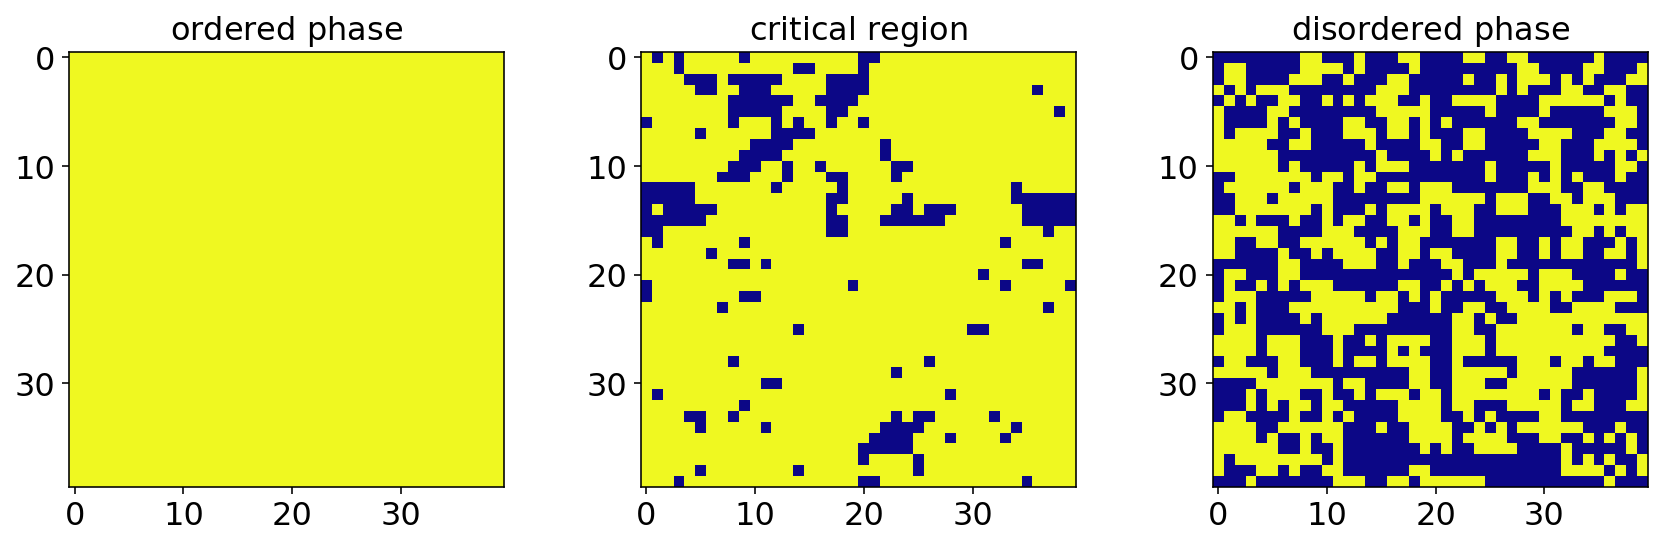

In [5]:
# set colourbar map
cmap_args = dict(cmap='plasma_r')

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(X_ordered[20001].reshape(L, L), **cmap_args)
axarr[0].set_title('$\\mathrm{ordered\\ phase}$', fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(X_critical[10001].reshape(L, L), **cmap_args)
axarr[1].set_title('$\\mathrm{critical\\ region}$', fontsize=16)
axarr[1].tick_params(labelsize=16)

im=axarr[2].imshow(X_disordered[50001].reshape(L,L),**cmap_args)
axarr[2].set_title('$\\mathrm{disordered\\ phase}$',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

fig.savefig(fig_path("ising_states.pdf"), bbox_inches='tight')
plt.show()

# Train Classifier with Newton-Raphson's Method

In [6]:
# use only 4 percent of the data in Newton-Raphson
X_train_nr, X_test_nr, y_train_nr, y_test_nr = logreg.split_data(X, y, test_ratio=0.96)

# small dataset for testing
#from sklearn import datasets
#iris = datasets.load_iris()
#X = iris["data"][:,]  # petal width
#y = (iris["target"] != 0) * 1  # 1 if Iris-Virginica, else 0
#X_train, X_test, y_train, y_test = logreg.split_data(X, y, test_ratio=0.33)
#X_critical = X_train[:50, :]
#y_critical = y_train[:50]
#X_train_nr = X_train
#X_test_nr = X_test
#y_train_nr = y_train
#y_test_nr = y_test

# fit training data
logreg = LogisticRegression(n_iter=5)
logreg.fit(X_train_nr, y_train_nr, method='NR', verbose=True)

# check accuracy
train_accuracy = logreg.accuracy(X_train_nr, y_train_nr)
test_accuracy = logreg.accuracy(X_test_nr, y_test_nr)
critical_accuracy = logreg.accuracy(X_critical, y_critical)
print('NR: %0.4f, %0.4f, %0.4f' %(train_accuracy, test_accuracy, critical_accuracy))

Initial weights: [0. 0. 0. ... 0. 0. 0.]
Iteration no: 0
New weight: [ 0.83285471  0.03173063 -0.12200644 ...  0.22281848 -0.03982835
  0.08252248]
L2 norm of weights: 6.371613162330846
L2 change 6.371613162330846
Log likelihood: -3024.60126362747
Cost: 3024.6012636274704
Accuracy: 82.921875
Iteration no: 1
New weight: [ 1.11141883e+00  7.22797676e-02 -1.90153889e-01 ...  3.14602926e-01
 -6.22949594e-04  9.43171860e-02]
L2 norm of weights: 10.640757348196
L2 change 4.547571374017521
Log likelihood: -2743.405354632332
Cost: 2743.405354632332
Accuracy: 84.546875
Iteration no: 2
New weight: [ 1.29052081  0.17254476 -0.24392162 ...  0.44538693  0.05371122
  0.05404577]
L2 norm of weights: 14.783545763702053
L2 change 4.433306526682639
Log likelihood: -2642.918471023525
Cost: 2642.9184710235254
Accuracy: 85.21875
Iteration no: 3
New weight: [ 1.37799556  0.29292403 -0.29973923 ...  0.5602943   0.0905749
  0.01994547]
L2 norm of weights: 17.384591414476656
L2 change 2.8151349378714534
Log li

# Train Classifier with Gradient Descent Method

In [ ]:
lmbdas=np.logspace(-5,5,11)

train_accuracy_gd = np.zeros(lmbdas.shape,np.float32)
test_accuracy_gd = np.zeros(lmbdas.shape,np.float32)
critical_accuracy_gd = np.zeros(lmbdas.shape,np.float32)

train_accuracy_nr = np.zeros(lmbdas.shape,np.float32)
test_accuracy_nr = np.zeros(lmbdas.shape,np.float32)
critical_accuracy_nr = np.zeros(lmbdas.shape,np.float32)

for i, lmbda in enumerate(lmbdas):

    print(f'Iteration no: {i + 1}/11')
    
    logreg2 = LogisticRegression(n_iter=1000, eta=0.0001, lmbda=lmbda)
    logreg2.fit(X_train, y_train)

    # check accuracy
    train_accuracy_gd[i] = logreg2.accuracy(X_train, y_train)
    test_accuracy_gd[i] = logreg2.accuracy(X_test, y_test)
    critical_accuracy_gd[i] = logreg2.accuracy(X_critical, y_critical)
    print(f'lambda = {lmbda}')
    print('accuracy: train, test, critical')
    print('GD: %0.4f, %0.4f, %0.4f' %(train_accuracy_gd[i],test_accuracy_gd[i],critical_accuracy_gd[i]) )
    
    logreg2 = LogisticRegression(n_iter=5, lmbda=lmbda)
    logreg2.fit(X_train, y_train, method='NR')

    # check accuracy
    train_accuracy_nr[i] = logreg2.accuracy(X_train_nr, y_train_nr)
    test_accuracy_nr[i] = logreg2.accuracy(X_test_nr, y_test_nr)
    critical_accuracy_nr[i] = logreg2.accuracy(X_critical, y_critical)
    
    print('NR: %0.4f, %0.4f, %0.4f' %(train_accuracy_nr[i],test_accuracy_nr[i],critical_accuracy_nr[i]) )
    print('')

fig = plt.gcf()

plt.semilogx(lmbdas,train_accuracy_nr,'*-b',label='NR train')
plt.semilogx(lmbdas,test_accuracy_nr,'*-r',label='NR test')
plt.semilogx(lmbdas,critical_accuracy_nr,'*-g',label='NR critical')

plt.semilogx(lmbdas,train_accuracy_gd,'*--b',label='GD train')
plt.semilogx(lmbdas,test_accuracy_gd,'*--r',label='GD test')
plt.semilogx(lmbdas,critical_accuracy_gd,'*--g',label='GD critical')

plt.xlabel('$\\lambda$')
plt.ylabel('$\\mathrm{accuracy}$')

plt.grid()
plt.legend()

fig.savefig(fig_path("logistic_ising_accuracy_regularization.pdf"), bbox_inches='tight')
plt.show()

Iteration no: 1/11


# ROC Curve

LogisticRegression AUC (Train): 0.28630952593640724
LogisticRegression AUC (Test): 0.27774139778545065
LogisticRegression AUC (Critical): 0.45712479749999996


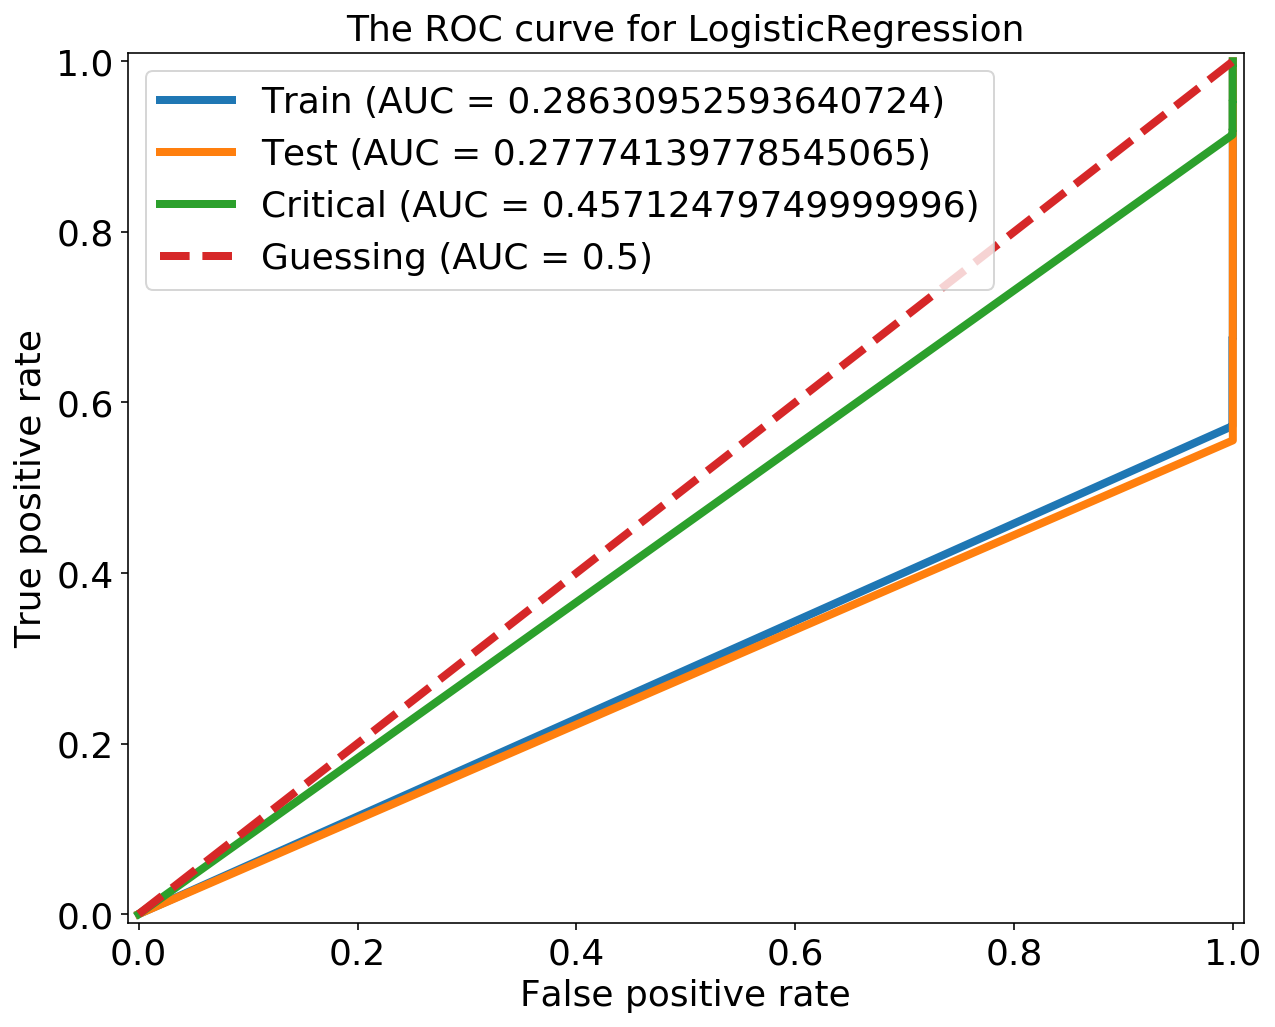

In [14]:
import sklearn.metrics as skm

X = np.load("spin_data.npy")
y = np.load("labels.npy")

# divide data into ordered, critical and disordered
X_ordered = X[:70000,:]
y_ordered = y[:70000]

X_critical = X[70000:100000,:]
y_critical = y[70000:100000]

X_disordered = X[100000:,:]
y_disordered = y[100000:]

# define training and test data sets
X = np.concatenate((X_ordered, X_disordered))
y = np.concatenate((y_ordered, y_disordered))

# create the training and test sets
logreg = LogisticRegression()
X_train, X_test, y_train, y_test = logreg.split_data(X, y, test_ratio=0.96)
logreg.fit(X_train, y_train)

fig = plt.figure(figsize=(10, 8))

for (_X, _y), label in zip([(X_train, y_train),(X_test, y_test), (X_critical, y_critical)], ["Train", "Test", "Critical"]):
    _X = np.c_[np.ones(_X.shape[0]), _X]
    proba = logreg.predict_proba(_X)
    fpr, tpr, _ = skm.roc_curve(_y, proba)
    roc_auc = skm.auc(fpr, tpr)

    print ("LogisticRegression AUC ({0}): {1}".format(label, roc_auc))

    plt.plot(fpr, tpr, label="{0} (AUC = {1})".format(label, roc_auc), linewidth=4.0)

plt.plot([0, 1], [0, 1], "--", label="Guessing (AUC = 0.5)", linewidth=4.0)

plt.title(r"The ROC curve for LogisticRegression", fontsize=18)
plt.xlabel(r"False positive rate", fontsize=18)
plt.ylabel(r"True positive rate", fontsize=18)
plt.axis([-0.01, 1.01, -0.01, 1.01])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc="best", fontsize=18)
fig.savefig(fig_path("logistic_roc_curve.pdf"), bbox_inches='tight')
plt.show()